## Airbnb Data Cleaning

Liqin Zhang - lz2809

In [24]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
print('all import succeed')

all import succeed


In [38]:
raw_df = pd.read_csv('/Users/liqin/Downloads/nyc_listing.csv')
print(f"Import {len(raw_df)} Airbnb listings")

Import 37713 Airbnb listings


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20211102175544,2021-11-03,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,a few days or more,35%,18%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,8.0,8.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,17,47,322,2021-11-03,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20211102175544,2021-11-03,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,a few days or more,21%,76%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Brooklyn, New York, United States",Bedford-Stuyvesant,Brooklyn,40.68494,-73.95765,Entire guest suite,Entire home/apt,3,NaN,1 bath,1.0,3.0,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",$73.00,1,730,1.0,1.0,730.0,730.0,1.0,730.0,NaN,t,4,10,33,220,2021-11-03,408,38,0,2015-01-05,2021-06-29,4.46,4.59,4.50,4.79,4.81,4.72,4.65,NaN,f,1,1,0,0,4.91
2,5121,https://www.airbnb.com/rooms/5121,20211102175544,2021-11-03,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",within a few hours,100%,100%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,NaN,1.0,1.0,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN

### Drop unused feature columns

In [40]:
drop_features = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(drop_features, axis=1)

In [41]:
df.isna().sum()

id                                                  0
host_since                                         31
host_response_time                              17058
host_response_rate                              17058
host_acceptance_rate                            16354
host_is_superhost                                  31
host_listings_count                                31
host_total_listings_count                          31
host_has_profile_pic                               31
host_identity_verified                             31
neighbourhood                                   15206
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

In [42]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)
df.set_index('id', inplace=True) 

In [43]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

31


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2835711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, United States",Greenwich Village,40.73058,-74.00070,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Stove"", ""Dedicated workspace"", ""Hair dryer"",...",$106.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,10,12,16,169,48,4,0,2018-11-24,2021-07-31,4.46,4.63,3.75,4.85,4.92,4.92,4.52,f,1,1,0,0,1.34
4446862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Crown Heights,40.67605,-73.95997,Private room in rental unit,Private room,2,NaN,1 bath,1.0,1.0,"[""Long term stays allowed"", ""TV"", ""Heating"", ""...",$50.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4763327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Greenpoint,40.72119,-73.95279,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Cable TV"", ""Hot t...",$195.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,1,0,0,2015-10-20,2015-10-20,4.00,4.00,5.00,5.00,4.00,5.00,4.00,f,1,1,0,0,0.01
6360224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bushwick,40.69977,-73.92912,Private room in rental unit,Private room,1,NaN,0 baths,1.0,1.0,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",$37.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,1,0,0,2015-07-01,2015-07-01,0.00,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,0.01
6992973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Williamsburg,40.71944,-73.95645,Entire rental unit,Entire home/apt,4,NaN,2 baths,2.0,1.0,"[""Long term stays allowed"", ""Shampoo"", ""Fire e...",$145.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [45]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


In [46]:
lat_long = df[['latitude', 'longitude']]

In [49]:
df.drop(['latitude', 'longitude', 'neighbourhood'], axis=1, inplace=True)

In [50]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1520

In [51]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

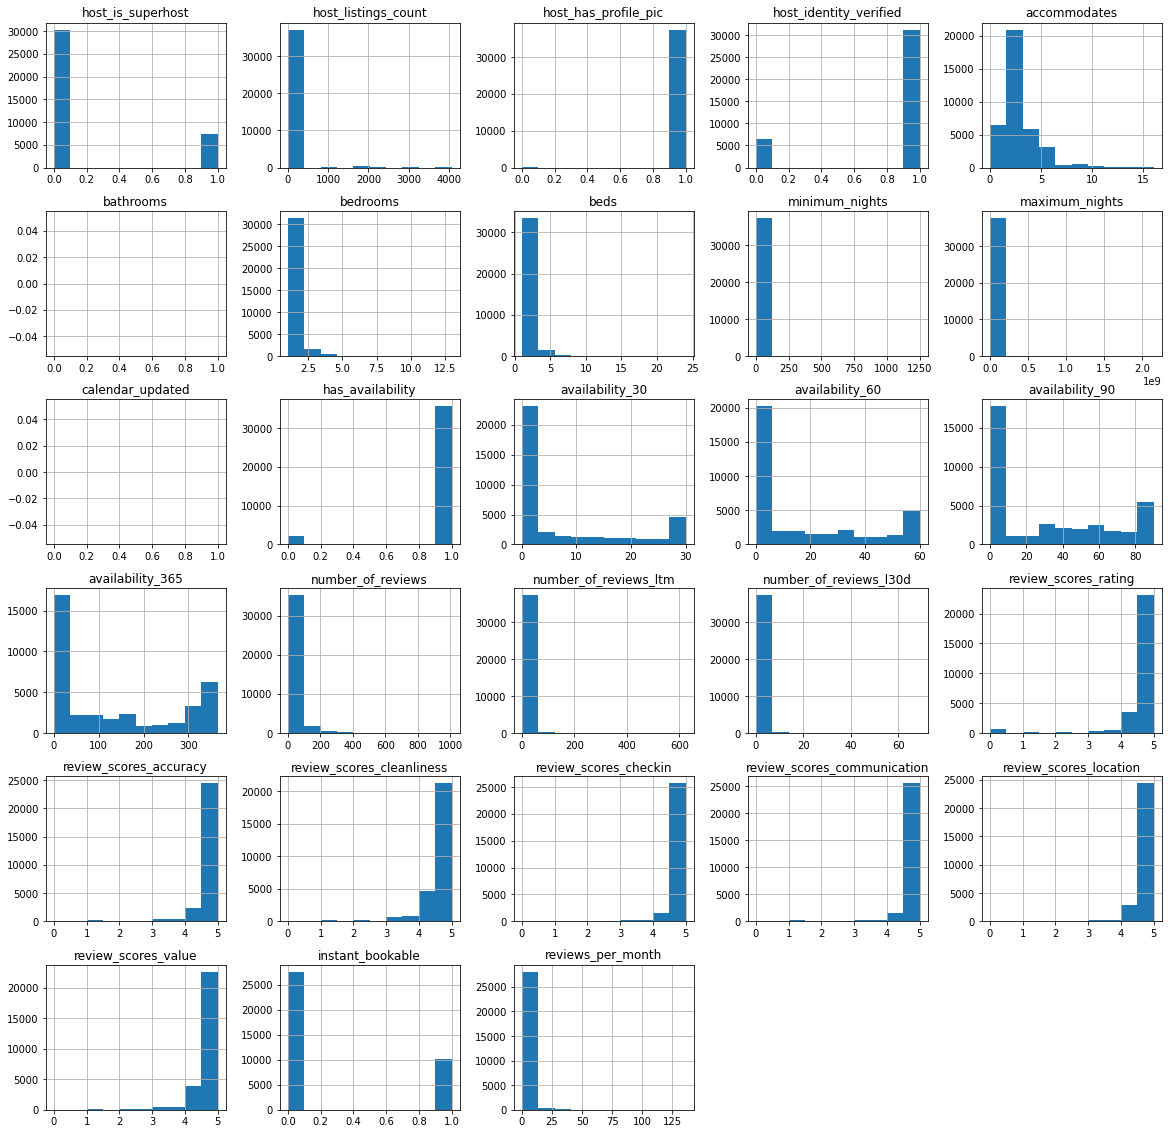

In [52]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to - message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month